# Cardiovascular Disease Prediction using Machine Learning Algorithms in Medical Field

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")



# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from yellowbrick.model_selection import learning_curve, feature_importances

# Missing Value
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.impute import KNNImputer


# Data Preprocessing
import phik
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler,OneHotEncoder
from imblearn.over_sampling import SMOTE

# Models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier




# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import recall_score

# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest

# Anomaly Detection
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Random State
random_state = 0

# Data Ingestion

In [2]:
patientDf=pd.read_csv("processed.cleveland.data",sep=',')

patientDf

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


# Data Exploration

### Data Structure

In [3]:
patientDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


The dataset contains 1 label and 13 features.There is a total of 303 rows of data in this dataset.
By viewing the basic information of the dataset,we realised 2 problem
 - Some feature's data type is incorrect. (E.g. Things like age and sex cannot be float numbers)
 - There is missing data but not identified by default Pandas.  (E.g. The data type of ca and thal is object which is abnormal but total non-null count is still 303.)

### Managing Missing Data


In [4]:
patientDf[np.isin(patientDf, ['?'])]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Previously,we found out that there is missing value in data.We realise that the missing value in this dataset is denoted as '?' which is not part of Panda's default NA values.

In [5]:
patientDf=pd.read_csv("processed.cleveland.data",sep=',',na_values='?')
patientDf.isna().sum().sort_values(ascending=False)

ca          4
thal        2
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
num         0
dtype: int64

In [6]:
patientDf[patientDf.isna().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,NaN,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,NaN,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,NaN,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,NaN,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,NaN,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


<AxesSubplot:title={'center':'Number of outlier in features'}>

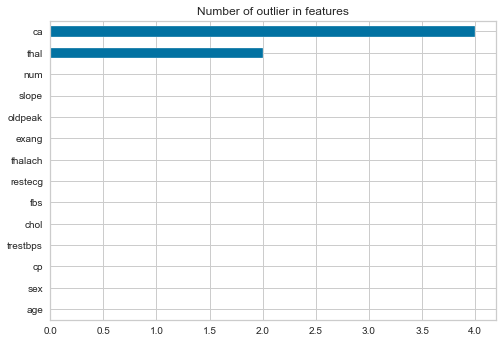

In [7]:
patientDf.isna().sum().sort_values().plot.barh(title='Number of outlier in features')


The missing data mainly assemble at ca and thal attribute.
At first glance ,we see that there is no common relation in missing data.It is very likely a MCAR mechanism.However,to further confirm our hypothesis,we carry out the little's MCAR Test.


| Type                               | Description                                                                                      |
|------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Missing completely at random(MCAR) | The causes of the missing data are unrelated to the data. We may consequently ignore many of the complexities that arise because data are missing, apart from the obvious loss of information. |
| Missing at random    (MAR)         | The probability of being missing is the same only within groups defined by the observed data                                                                                                   |
| Missing not at random (MNAR)       | The probability of being missing varies for reasons that are unknown to us.                                                                                                                    |

In [8]:
mt= MCARTest(method='little')
little=pd.DataFrame({"Subject":["Chi-Square Test hypothesis test"],"P-value":[mt.little_mcar_test(patientDf)]})


little

,Subject,P-value
0,Chi-Square Test hypothesis test,0.892389


$H_{0}$ : Data is MCAR
$H_{1}$ : Data is not MCAR

We see that p value=0.8923 >a=0.05.It is not rare to have data being MCAR.Hence,there is insufficient evidence to reject H0 that data is MCAR.Therefore, we conclude that the data is MCAR.In this case ,we will proceed with using K-Nearest Neighbors Imputer to substitute missing values.

In [9]:
impuiter=KNNImputer(n_neighbors=5,weights='uniform')
patientDf=pd.DataFrame(impuiter.fit_transform(patientDf),columns=patientDf.columns)
patientDf

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1.0


### Converting Data Structure

In [10]:
patientDf=patientDf.astype({'age':np.int64,'sex':np.int64,'cp':np.int64,'trestbps':np.int64,'chol':np.int64,'exang':np.int64,'slope':np.int64,'ca':np.int64,'thal':np.int64,'fbs':np.int64,'restecg':np.int64,'thalach':np.int64,'num':np.int64})
patientDf.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
num           int64
dtype: object

### Label Formatting

In [11]:
patientDf.loc[patientDf['num'] > 0, 'num'] = 1

### Target Predictor

Text(0.5, 1.0, 'Distribution of target label')

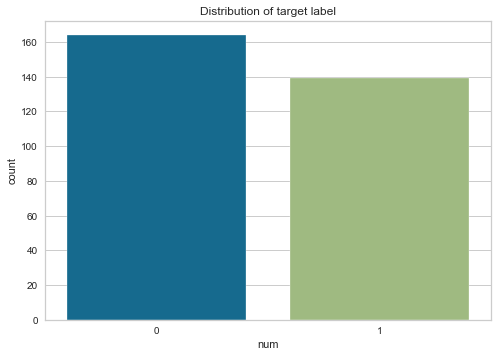

In [12]:
sns.countplot(data=patientDf,x='num').set_title('Distribution of target label')

Looking at the distribution of data for our target predictor,we realise that the data is only slightly  imbalanced.Number of patients with cardiovascular disease are slightly lesser than number of patients with no cardiovascular disease.We may consider doing oversampling based on the performace of model later.

#### Quantitative Variables

In [13]:
quantitativeVariables=['age','trestbps','chol','thalach','oldpeak',ca]

#### Qualitative Variables

In [14]:
quatitativeVariables=['sex','cp','restecg','exang','slope','thal','fbs']

#### Univariate Analysis

In [15]:
patientDf[quantitativeVariables].describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604
std,9.038662,17.599748,51.776918,22.875003,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000
75%,61.000000,140.000000,275.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'trestbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'thalach'}>],
       [<AxesSubplot:title={'center':'oldpeak'}>, <AxesSubplot:>]],
      dtype=object)

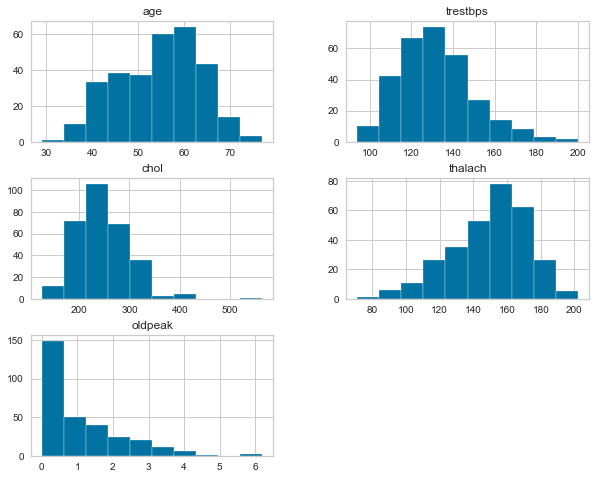

In [16]:
patientDf[quantitativeVariables].hist(figsize=(10, 8))

In [17]:
Q1 = patientDf.trestbps.quantile(0.25)
Q3 = patientDf.trestbps.quantile(0.75)
IQR = Q3 - Q1
patientDf[patientDf.trestbps >Q3 + 1.5 * IQR]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
14,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
83,68,1,3,180,274,1,2,150,1,1.6,2,0,7,1
126,56,0,4,200,288,1,2,133,1,4.0,3,2,7,1
172,59,0,4,174,249,0,0,143,1,0.0,2,0,3,1
183,59,1,1,178,270,0,2,145,0,4.2,3,0,7,0
188,54,1,2,192,283,0,2,195,0,0.0,1,1,7,1
201,64,0,4,180,325,0,0,154,1,0.0,1,0,3,0
213,66,0,4,178,228,1,0,165,1,1.0,2,2,7,1
231,55,0,4,180,327,0,1,117,1,3.4,2,0,3,1


C:\Users\ZHUOFANCHEN\AppData\Local\Temp\ipykernel_16304\596233111.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


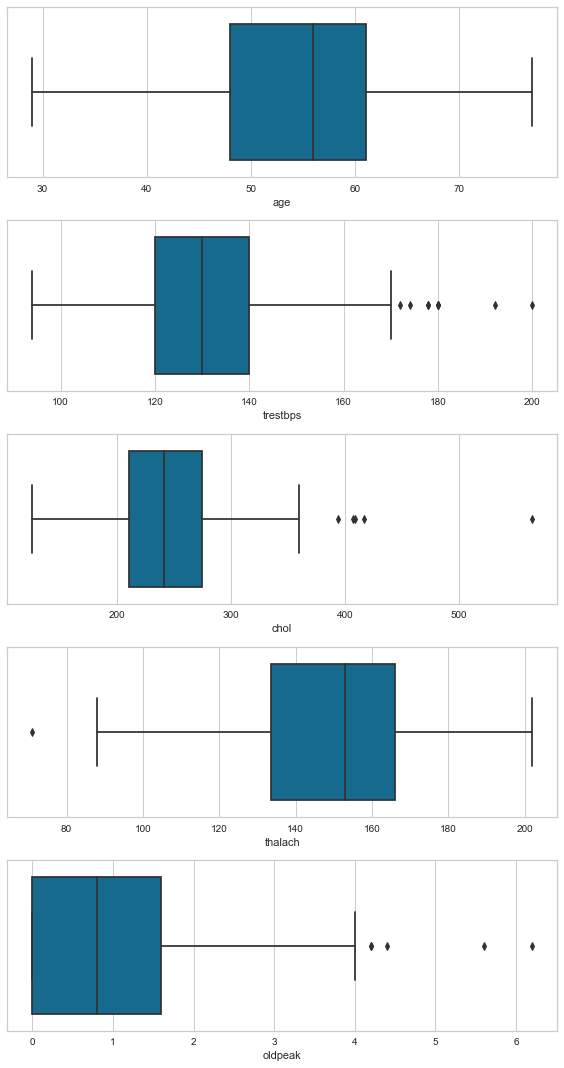

In [18]:

fig, ax = plt.subplots(len(quantitativeVariables), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quantitativeVariables):
    sns.boxplot(data=patientDf, x=feature, ax = ax[idx])
fig.show()

#### Bivariate Analysis

C:\Users\ZHUOFANCHEN\AppData\Local\Temp\ipykernel_16304\3328828856.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


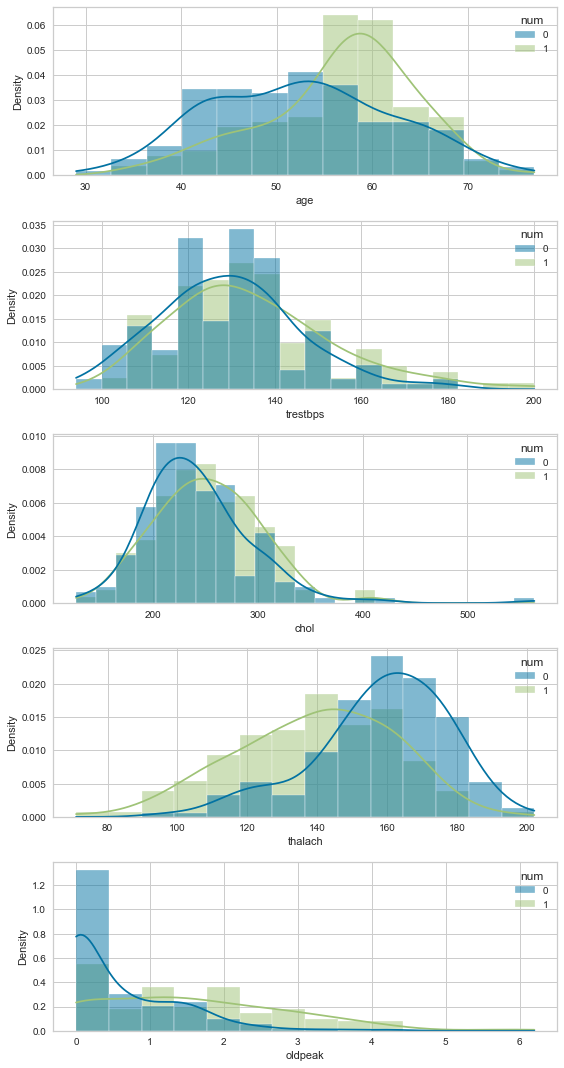

In [19]:


fig, ax = plt.subplots(len(quantitativeVariables), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quantitativeVariables):

    sns.histplot(data=patientDf,common_norm = False,stat='density', x=feature, hue="num",ax=ax[idx],kde=True)
fig.show()


C:\Users\ZHUOFANCHEN\AppData\Local\Temp\ipykernel_16304\3395522737.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


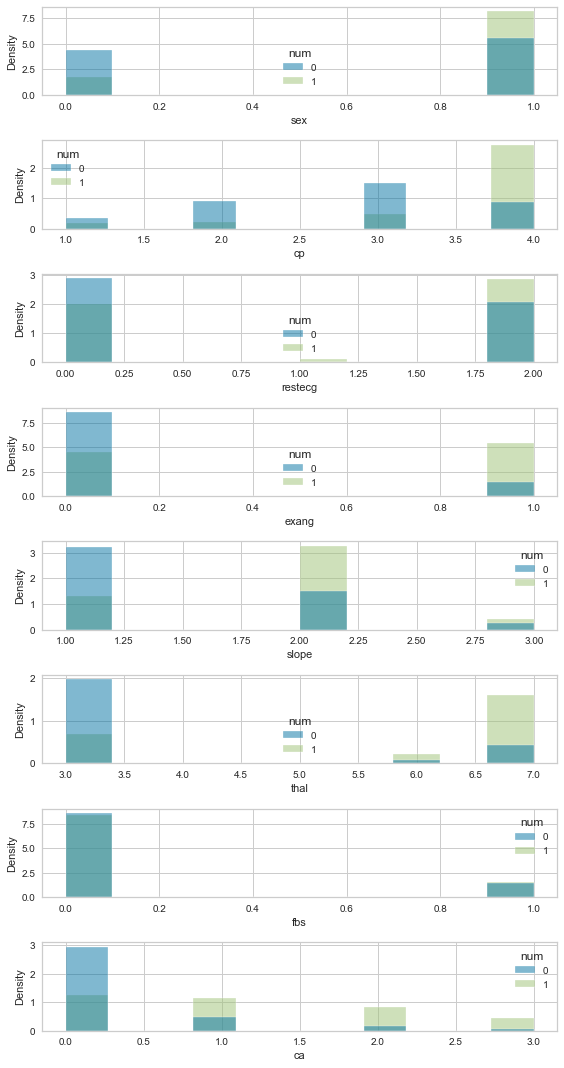

In [20]:

fig, ax = plt.subplots(len(quatitativeVariables), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quatitativeVariables):

    sns.histplot(data=patientDf,common_norm = False, stat='density',x=feature, hue="num",ax=ax[idx])
fig.show()

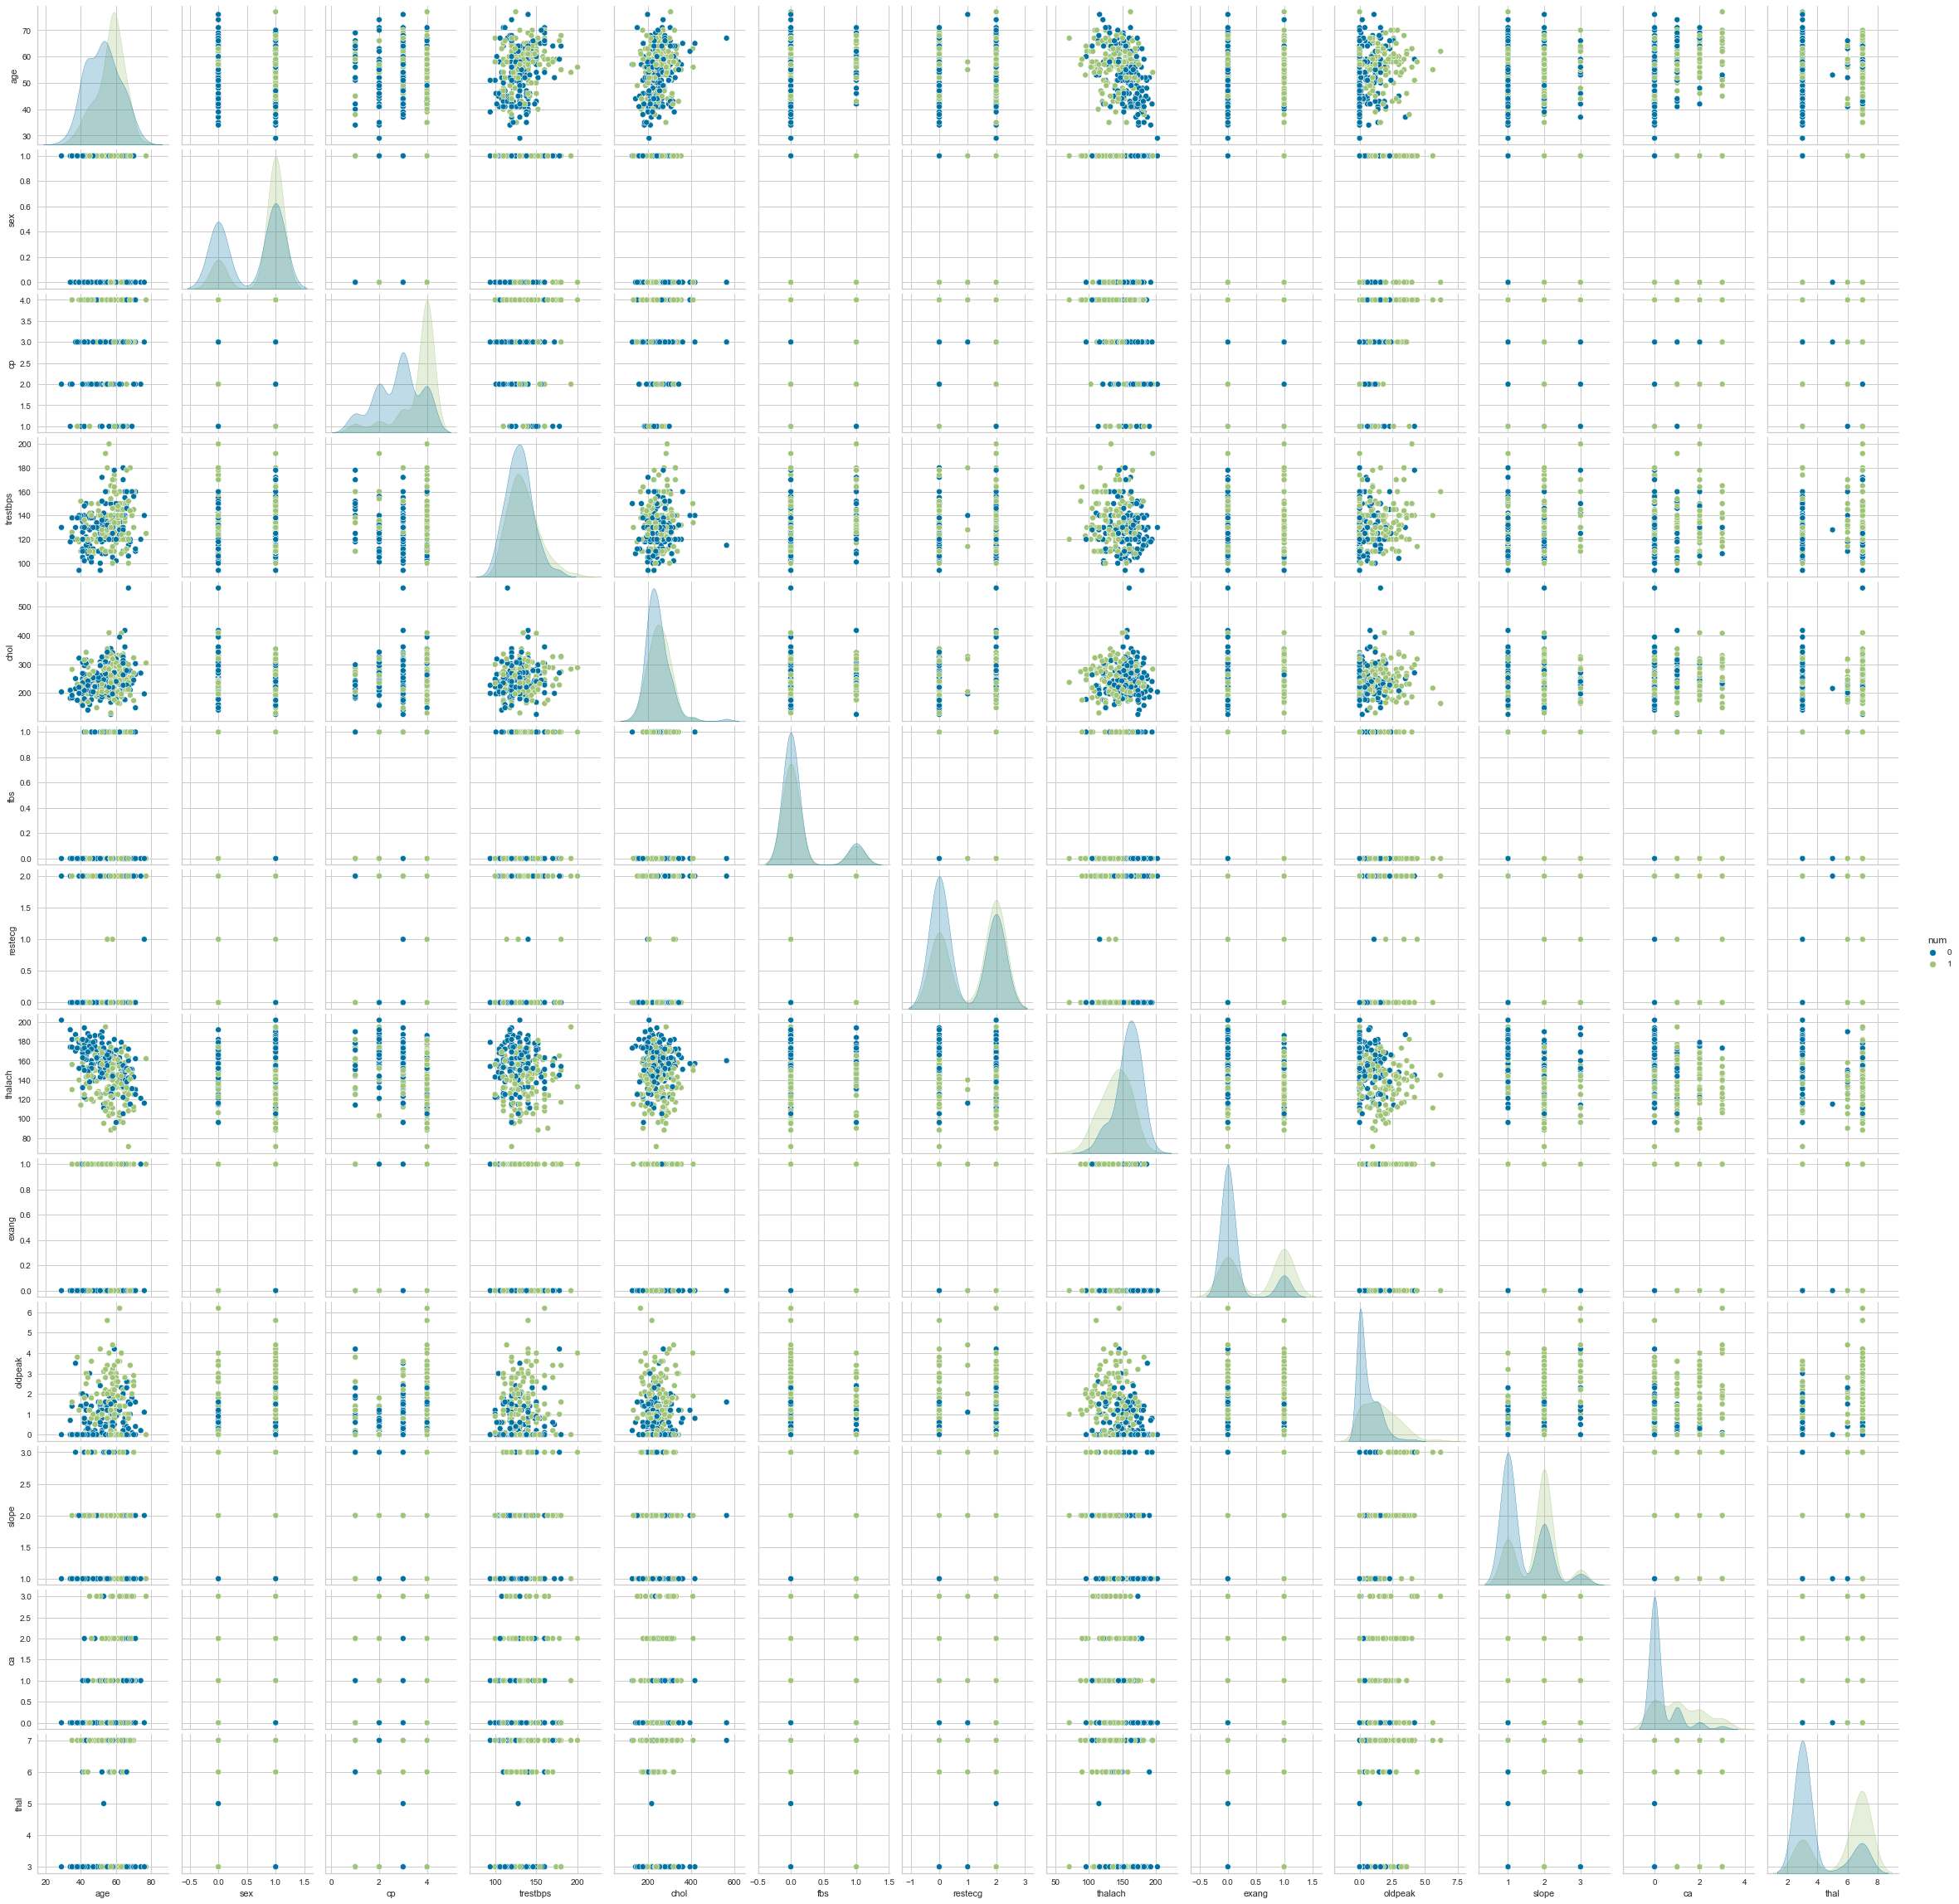

In [21]:
sns.pairplot(patientDf, hue="num")

Text(0.5, 1.0, 'Correlation Matrix')

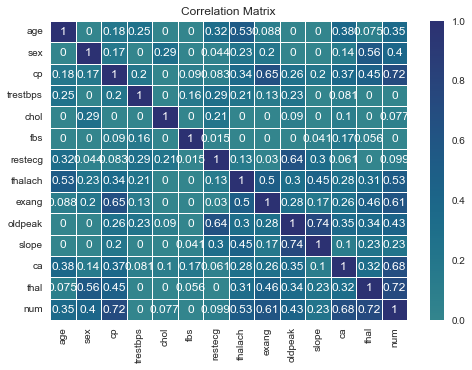

In [22]:

corr_matrix = patientDf.phik_matrix(interval_cols=patientDf.columns)

sns.heatmap(corr_matrix, annot = True, linewidths=.5,center = 0,cmap="crest").set_title('Correlation Matrix')

Looking at the correlation matrix,we did not find any features that is too correlated.The feature that has the highest correction were the cp and thal thalach feature which both have a correlation of 0.72 .  However ,we found 2 features: trestbps and fbs that have 0 correlation.We would have directly removed it if we are only doing linear classifier.However,since we are using non-linear classifier ,we should not remove it now, but we will train and test the model with and without the 2 features later and then determine whether the remove them.

# Data Pre-Processing

### Feature Selection

### Feature Scaling

In [23]:
quantitativeTransformer=Pipeline([
     ('Robust Scaler', RobustScaler())
])
categorical_transformers = Pipeline([
    ('One Hot Encoder', OneHotEncoder(handle_unknown='ignore'))
])
data_preprocessing = ColumnTransformer([
    ('Preprocess Numerical Features', quantitativeTransformer, quantitativeVariables),
       ('Preprocess Categorical Features', categorical_transformers, quatitativeVariables)
])

# Training Data and Test Data

In [24]:

x_train, x_test, y_train, y_test = train_test_split(patientDf. loc[:, patientDf. columns != 'num'],patientDf['num'], random_state = 42, stratify=patientDf.num, test_size = .20)

In [25]:
x_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
219,59,1,4,138,271,0,2,182,0,0.0,1,0,3
271,66,1,4,160,228,0,2,138,0,2.3,1,0,6
89,51,0,3,130,256,0,2,149,0,0.5,1,0,3
101,34,1,1,118,182,0,2,174,0,0.0,1,0,3
67,54,1,3,150,232,0,2,165,0,1.6,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,58,1,4,114,318,0,1,140,0,4.4,3,3,6
243,61,1,1,134,234,0,0,145,0,2.6,2,2,3
94,63,0,3,135,252,0,2,172,0,0.0,1,0,3
291,55,0,2,132,342,0,0,166,0,1.2,1,0,3


# Model and Evalutaion

In [26]:
def scoreModel(clf,x,y,algName=None,record=pd.DataFrame({'name':[],'train_accuracy':[],'test_accuracy':[],'test_recall':[],'train_recall':[]})):
    '''
    This function is used for model evaluation . This function use scikit-learn library to carry out cross validation using StratifiedKFold. The scoring metrics are accuracy and balanced accuracy

    :param clf: Classifier 分类器
    :param x:Train Data X(Data)  训练数据 （数据）
    :param y:Train Data Y(Result)  训练数据（结果）
    :param algName: Name of Algorithm used for recording 算法名字
    :param record: History record dataframe 在历史记录上叠加结果
    :return:
    This function return 3 variable: 这个函数返回三个参数
    record: Dataframe with current and past record(if there is any)
    current: Dataframe with current record
    lr: Learning curve
    '''
    score=cross_validate(clf,x,y,cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,),scoring=['accuracy','recall'],n_jobs=-1,return_estimator=True,return_train_score=True)
    current=pd.DataFrame({'name':[algName],'train_accuracy':score['train_accuracy'].mean(),'test_accuracy':score['test_accuracy'].mean(),'test_recall':score['test_recall'].mean(),'train_recall':score['train_recall'].mean()})
    record=pd.concat([record,current],ignore_index=True)
    lr = learning_curve(clf, x, y, scoring = 'recall', cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,), n_jobs=-1)
    return record,current,lr



## Baseline Model

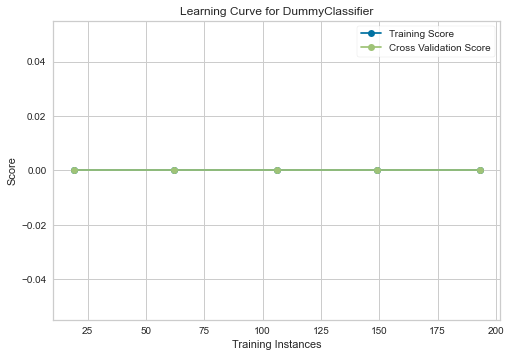

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Dummy Baseline Classifier,0.541323,0.541327,0.0,0.0


In [27]:
baseline = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', DummyClassifier())
])
record,current,lr=scoreModel(baseline,x_train,y_train,"Dummy Baseline Classifier")
current

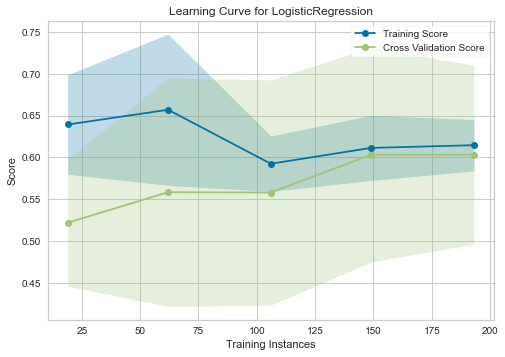

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Logistic Regression,0.708664,0.689796,0.603162,0.612615


In [28]:
logreg = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', LogisticRegression(solver='lbfgs'))
])
record,current,lr=scoreModel(logreg,x_train,y_train,"Logistic Regression",record=record)
current

## Gaussian Naive Bayes

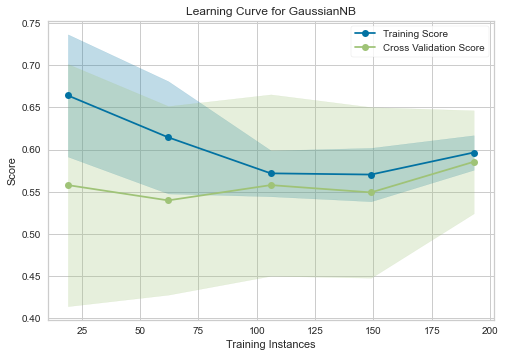

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Gaussian Naive Bayes,0.713824,0.697874,0.585375,0.59691


In [29]:
gaussNB = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', GaussianNB())
])
record,current,lr=scoreModel(gaussNB,x_train,y_train,"Gaussian Naive Bayes",record=record)
current

## Decision Tree

In [34]:

parameter={'max_depth':np.arange(1,10)}
pd.DataFrame(GridSearchCV(DecisionTreeClassifier(),param_grid=parameter,scoring='recall',cv = StratifiedKFold(n_splits = 5, shuffle = True,random_state=0)).fit(x_train,y_train).cv_results_)
# print(max_depth)
# path=pd.DataFrame(DecisionTreeClassifier(random_state=random_state).cost_complexity_pruning_path(x_train,y_train))
# ccp_alphas,impurities=path.ccp_alphas,path.impurities
# clfs = []
# clf=DecisionTreeClassifier(random_state=0)
# for ccp_alpha in ccp_alphas:
#     clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
#     clf.fit(x_train, y_train)
#     clfs.append(clf)
# clfs = clfs[:-1]
# ccp_alphas = ccp_alphas[:-1]
# y_pred = clf.predict(x_train)
# y_score = clf.score(x_train, y_train)
# t_pred = clf.predict(x_test)
# t_score = clf.score(x_test, y_test)
# node_counts = [clf.tree_.node_count for clf in clfs]
# depth = [clf.tree_.max_depth for clf in clfs]
# train_scores = [metrics.recall_score(y_pred, y_train) for clf in clfs]
# test_scores = [metrics.recall_score(t_pred, y_test) for clf in clfs]
#
# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
# print(ccp_alphas)
# ax.legend()
# plt.show()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002118,0.000496,0.001996,0.000627,1,{'max_depth': 1},0.652174,0.545455,0.363636,0.727273,0.636364,0.584980,0.124866,9
1,0.002280,0.000536,0.002023,0.000570,2,{'max_depth': 2},0.695652,0.363636,0.909091,0.863636,0.500000,0.666403,0.208812,8
2,0.001599,0.000490,0.001200,0.000401,3,{'max_depth': 3},0.652174,0.454545,0.727273,0.772727,0.727273,0.666798,0.112961,7
3,0.002034,0.000068,0.002001,0.000895,4,{'max_depth': 4},0.608696,0.681818,0.772727,0.772727,0.727273,0.712648,0.061951,4
4,0.003476,0.001780,0.003177,0.001993,5,{'max_depth': 5},0.565217,0.772727,0.772727,0.727273,0.681818,0.703953,0.077125,6
5,0.003877,0.001771,0.003416,0.001879,6,{'max_depth': 6},0.652174,0.772727,0.818182,0.636364,0.681818,0.712253,0.070955,5
6,0.003216,0.000766,0.002303,0.000392,7,{'max_depth': 7},0.652174,0.772727,0.863636,0.681818,0.636364,0.721344,0.085388,3
7,0.002475,0.000617,0.001400,0.000489,8,{'max_depth': 8},0.652174,0.772727,0.818182,0.727273,0.681818,0.730435,0.059978,2
8,0.002242,0.000388,0.002200,0.000748,9,{'max_depth': 9},0.695652,0.772727,0.818182,0.727273,0.681818,0.739130,0.050386,1


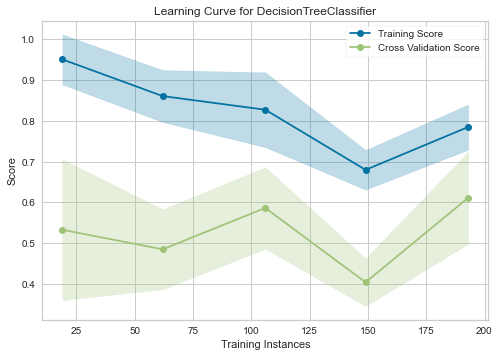

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Decision Tree Classifier,0.825437,0.656888,0.620553,0.783861


In [36]:
# bestccpAlpha=0.05227
DeciTree = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', DecisionTreeClassifier(max_depth=4))
])
record,current,lr=scoreModel(DeciTree,x_train,y_train,"Decision Tree Classifier",record=record)
current

## Random Forest

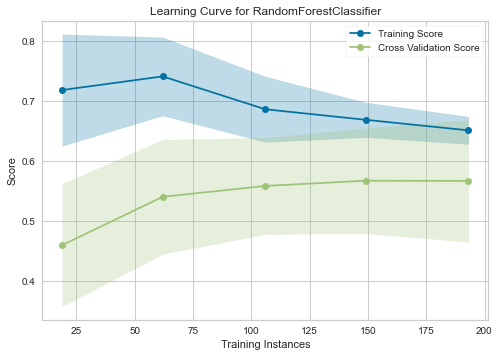

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Random Forest,0.752075,0.689796,0.611858,0.646476


In [32]:
randomFor = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', RandomForestClassifier(n_jobs=-1,max_depth=2))
])
record,current,lr=scoreModel(randomFor,x_train,y_train,"Random Forest",record=record)
current

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':np.arange(1,10),}
pd.DataFrame(GridSearchCV(SVC(),param_grid=parameters,scoring='recall',cv = StratifiedKFold(n_splits = 5, shuffle = True),n_jobs=-1).fit(x_train,y_train).cv_results_)

## SVM

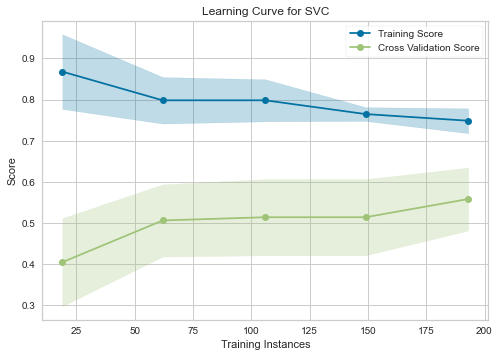

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,SVM Classifier,0.837818,0.652721,0.566798,0.74788


In [87]:

svm = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', SVC(C=10))
])
record,current,lr=scoreModel(svm,x_train,y_train,"SVM Classifier",record=record)
current

## Gradient Boosting Tree

In [61]:
parameter={'max_depth':np.arange(1,6)}
pd.DataFrame(GridSearchCV(GradientBoostingClassifier(learning_rate=2),param_grid=parameter,scoring='recall',cv = StratifiedKFold(n_splits = 5, shuffle = True),n_jobs=-1).fit(x_train,y_train).cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043618,0.004706,0.002462,0.002075,1,{'max_depth': 1},0.347826,0.272727,1.000000,0.000000,1.000000,0.524111,0.405439,4
1,0.078208,0.017597,0.005234,0.005693,2,{'max_depth': 2},0.043478,0.545455,0.181818,0.181818,0.681818,0.326877,0.243376,5
2,0.107232,0.028720,0.001524,0.003047,3,{'max_depth': 3},0.652174,0.818182,0.363636,0.545455,0.590909,0.594071,0.147699,3
3,0.121439,0.030322,0.002775,0.002303,4,{'max_depth': 4},0.608696,0.863636,0.636364,0.409091,0.545455,0.612648,0.148002,2
4,0.083366,0.022735,0.001002,0.002004,5,{'max_depth': 5},0.695652,0.818182,0.636364,0.636364,0.545455,0.666403,0.089806,1


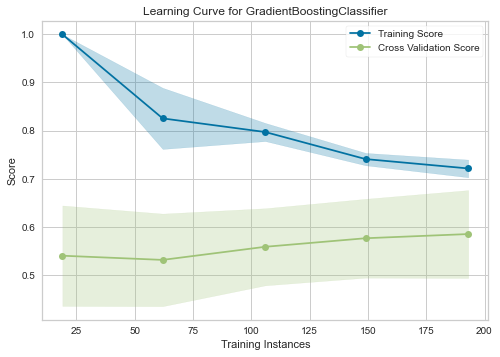

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Gradient Boosting Classifier,0.826441,0.710544,0.602767,0.727528


In [83]:





gradbt = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', GradientBoostingClassifier(max_depth=2,learning_rate=0.04))
])
record,current,lr=scoreModel(gradbt,x_train,y_train,"Gradient Boosting Classifier",record=record)
current

## LightGBM

In [ ]:
lgbmC = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', LGBMClassifier())
])
record,current,lr=scoreModel(lgbmC,x_train,y_train,"LightGBM Classifier",record=record)
current

## K-Nearest Neighbour

In [ ]:
knnClassifier = Pipeline([
    ('Data Preprocessing', data_preprocessing),
    ('Model', KNeighborsClassifier())
])
record,current,lr=scoreModel(knnClassifier,x_train,y_train,"K-Nearest Neighbour Classifier",record=record)
current

## Result Analysis

In [88]:
record

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Dummy Baseline Classifier,0.541323,0.541327,0.000000,0.000000
1,Logistic Regression,0.708664,0.689796,0.603162,0.612615
2,Gaussian Naive Bayes,0.713824,0.697874,0.585375,0.596910
3,Decision Tree Classifier,0.824400,0.656888,0.620553,0.786134
4,Random Forest,0.752075,0.689796,0.611858,0.646476
5,Decision Tree Classifier,0.975215,0.615816,0.601976,0.957252
6,Decision Tree Classifier,0.825437,0.656888,0.620553,0.783861
7,Gradient Boosting Classifier,0.757230,0.677296,0.611858,0.691496
8,Gradient Boosting Classifier,0.911175,0.665221,0.549407,0.853703
9,Gradient Boosting Classifier,0.770632,0.689796,0.630040,0.711772
